<a href="https://colab.research.google.com/github/mansikataria/FacialExpressionRecognition/blob/main/FERWithResnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install watermark


In [3]:
%load_ext watermark
%watermark -a 'Mansi Kataria' -v -p torch

Author: Mansi Kataria

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 5.5.0

torch: 1.9.0+cu102



Reading the FER2013 dataset from the CSV

In [4]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks'
sys.path.insert(0,BASE_PATH)

FER2013_PATH_FILE_NAME = 'fer2013.csv'

data = pd.read_csv(BASE_PATH + '/' + FER2013_PATH_FILE_NAME)

print(data)


       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [7]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Visualizations on the data:

1. Let's see the class distribution

In [8]:
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


Plotting a bar graph with these values:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


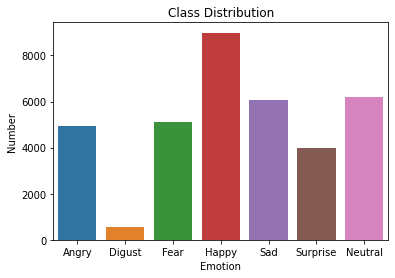

In [9]:
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class Distribution')
plt.ylabel('Number', fontsize=10)
plt.xlabel('Emotion', fontsize=10)
plt.show()

Plotting some sample images:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spec

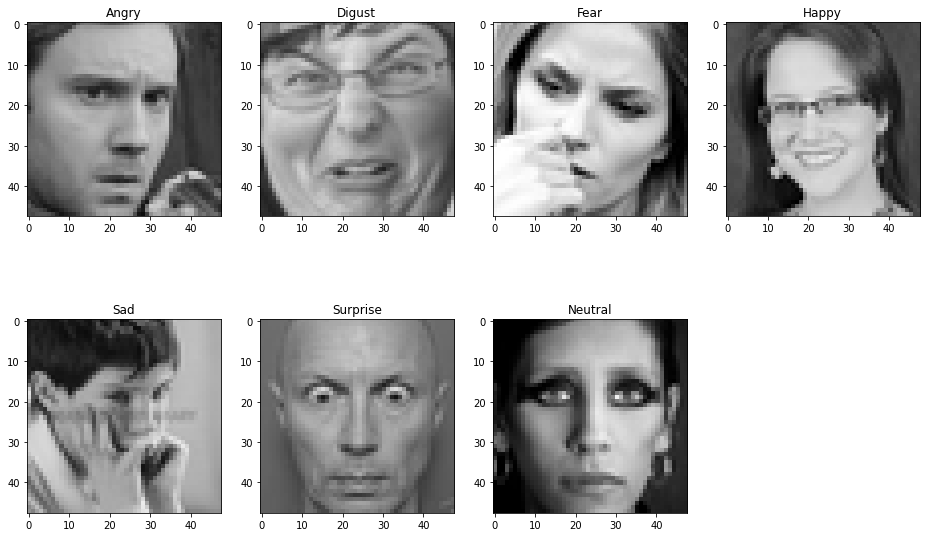

In [10]:
def row2Image(row):
  pixels, emotions = row['pixels'] , emotion_map[row['emotion']]
  img = np.array(pixels.split())
  img = img.reshape((48, 48))
  image = np.zeros((48, 48, 3))
  image[:,:, 0] = img
  image[:,:, 1] = img
  image[:,:, 2] = img
  return np.array([image.astype(np.uint8), emotions])



plt.figure(0, figsize=(16, 10))
for i in range(1, 8):
  face = data[data['emotion'] == i-1].iloc[0]
  img = row2Image(face)
  plt.subplot(2,4,i)
  plt.imshow(img[0])
  plt.title(img[1])

plt.show()

Splitting data into train, test and validation sets:


In [11]:
data_train = data[data['Usage'] == 'Training'].copy()
data_val = data[data['Usage'] == 'PublicTest'].copy() 
data_test = data[data['Usage'] == 'PrivateTest'].copy()

print("Train Shape: {}\nTest Shape: {}\nValidation Shape: {}".format(data_train.shape, data_test.shape, data_val.shape));

Train Shape: (28709, 3)
Test Shape: (3589, 3)
Validation Shape: (3589, 3)


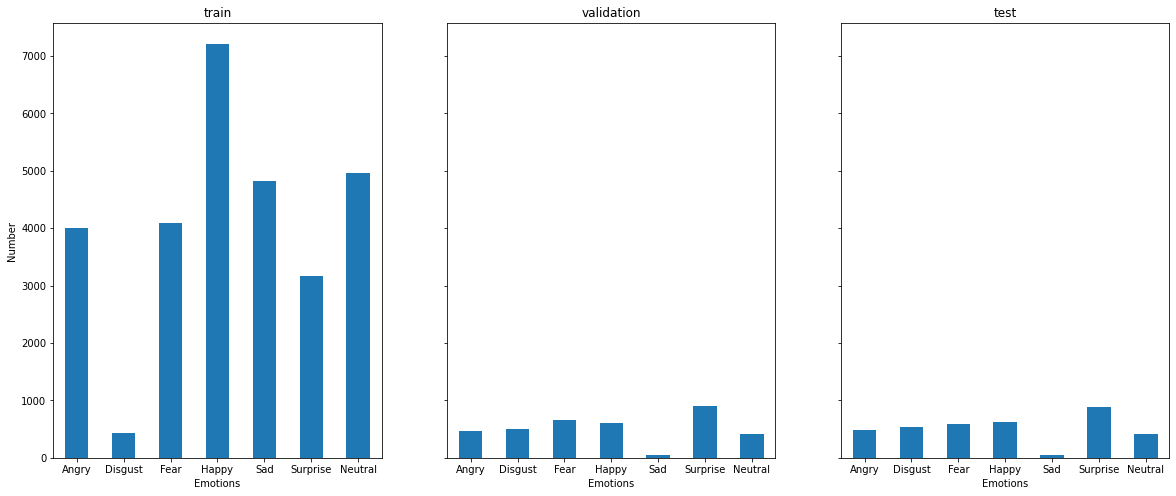

In [12]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

In [13]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [16]:
from skimage.transform import resize

# Size of the images
img_height, img_width = 197, 197

#image preprocessing:
def preprocess(df):
  #Convert string to int
  # df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  # #reshape and normalize
  # data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)
  pixels = data['pixels'].tolist()
  images = np.empty((len(data), 48, 48, 3))
  i = 0
  for pixel_sequence in pixels:
        single_image = [float(pixel) for pixel in pixel_sequence.split(' ')]  # Extraction of each single
        single_image = np.asarray(single_image).reshape(48, 48) # Dimension: 48x48
        # single_image = resize(single_image, (img_height, img_width), order = 3, mode = 'constant') # Dimension: 139x139x3 (Bicubic)
        ret = np.empty((48, 48, 3))  
        ret[:, :, 0] = single_image
        ret[:, :, 1] = single_image
        ret[:, :, 2] = single_image
        images[i, :, :, :] = ret
        i += 1
  # images = preprocess_input(images)
  labels = to_categorical(data['emotion'], num_classes)
  print("X shape: {},  Y shape: {}".format(images.shape, labels.shape))
  return images, labels    
  # data_Y = df['emotion'] 
  # return data_X, data_Y

print('Preprocessing Training Data...')
data_train_X, data_train_Y = preprocess(data_train)
print('Preprocessing Testing Data...')
data_test_X, data_test_Y = preprocess(data_test)
print('Preprocessing Validation Data...')
data_val_X, data_val_Y = preprocess(data_val)


Preprocessing Training Data...
X shape: (35887, 48, 48, 3),  Y shape: (35887, 7)
Preprocessing Testing Data...
X shape: (35887, 48, 48, 3),  Y shape: (35887, 7)
Preprocessing Validation Data...
X shape: (35887, 48, 48, 3),  Y shape: (35887, 7)


Visualizing Data Augmentation

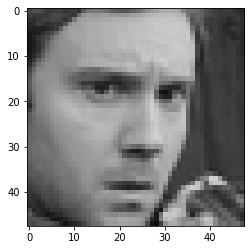

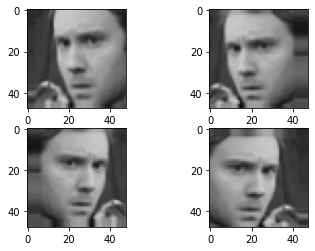

In [19]:
#Add some more data using augmentation
from keras.preprocessing.image import ImageDataGenerator
data_generator_test = ImageDataGenerator(
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=-.1,
                        horizontal_flip=True)

fig = plt.figure()

img = data_train_X[:1][0]
# result = np.concatenate([img,img,img], axis = -1)
plt.imshow(img.astype('uint8'))
plt.show()

data_generator_test.fit(data_train_X[:1])

i=0
for img_batch in data_generator_test.flow(data_train_X[:1], batch_size=4):
    for image in img_batch:
        plt.subplot(2, 2, i+1)
        # result = np.concatenate([image,image,image], axis = -1)
        plt.imshow(image.astype('uint8'))
        i=i+1    
    if i >= 4:
          break
    
plt.show()


Normalize the pixels


In [20]:
data_train_X /= 255
data_val_X /= 255
data_test_X /= 255

In [21]:
print(data_train_X[:1])
print(data_train_Y[:5])


[[[[0.2745098  0.2745098  0.2745098 ]
   [0.31372549 0.31372549 0.31372549]
   [0.32156863 0.32156863 0.32156863]
   ...
   [0.20392157 0.20392157 0.20392157]
   [0.16862745 0.16862745 0.16862745]
   [0.16078431 0.16078431 0.16078431]]

  [[0.25490196 0.25490196 0.25490196]
   [0.23921569 0.23921569 0.23921569]
   [0.22745098 0.22745098 0.22745098]
   ...
   [0.21960784 0.21960784 0.21960784]
   [0.20392157 0.20392157 0.20392157]
   [0.17254902 0.17254902 0.17254902]]

  [[0.19607843 0.19607843 0.19607843]
   [0.16862745 0.16862745 0.16862745]
   [0.21176471 0.21176471 0.21176471]
   ...
   [0.19215686 0.19215686 0.19215686]
   [0.21960784 0.21960784 0.21960784]
   [0.18431373 0.18431373 0.18431373]]

  ...

  [[0.35686275 0.35686275 0.35686275]
   [0.25490196 0.25490196 0.25490196]
   [0.16470588 0.16470588 0.16470588]
   ...
   [0.28235294 0.28235294 0.28235294]
   [0.21960784 0.21960784 0.21960784]
   [0.16862745 0.16862745 0.16862745]]

  [[0.30196078 0.30196078 0.30196078]
   [0.3

In [ ]:
data_train_X[:2].shape

Building a CNN Model:

In [31]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import Dense, Conv2D, Flatten,  MaxPooling2D, BatchNormalization, Activation #, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, Callback
# from keras.regularizers import l2

In [34]:
#create model
model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(48, 48, 3),
    pooling="max"
)
# add new classifier layers
x = model.output
x =  Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = model.input, outputs = predictions)

# flat1 = Flatten()(model.layers[-1].output)
# class1 = Dense(1024, activation='relu')(flat1)
# output = Dense(7, activation='softmax')(class1)

# define new model
# model = Model(inputs=model.inputs, outputs=output)

#model compile specifics
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=SGD(learning_rate=0.001, momentum=0.0001),
              metrics=['categorical_accuracy'])

# This callback writes a log for TensorBoard, which allows you to visualize dynamic graphs of your training and test metrics, 
# tensorboard_all_layers = TensorBoard(
#     log_dir         = BASE_PATH  + '/logs_all_layers',
#     histogram_freq  = 0,
#     write_graph     = True,
#     write_grads     = False,
#     write_images    = True)

# early_stop = EarlyStopping(
# 	monitor 	= 'val_loss',
# 	patience 	= 10,
# 	mode 		= 'auto')


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
len(data_train_X)

In [35]:
data_generator = ImageDataGenerator(
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=-.1,
                        horizontal_flip=True)

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# num_folds = 10
# # Define per-fold score containers <-- these are new
# acc_per_fold = []
# loss_per_fold = []
# # Merge inputs and targets
# inputs = np.concatenate((data_train_X, data_val_X), axis=0)
# targets = np.concatenate((data_train_Y, data_val_Y), axis=0)
# # Define the K-fold Cross Validator
# kfold = StratifiedKFold(n_splits=num_folds, shuffle=True)

# fold_no = 1
# for train, test in kfold.split(inputs, targets):
#   targets = to_categorical(targets, num_classes) 
#   #create model
#   model = tf.keras.applications.ResNet50(
#       include_top=True,
#       weights=None,
#       input_tensor=None,
#       input_shape=(48, 48, 1),
#       pooling="max",
#       classes=7
#   )

#   #model compile specifics
#   model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
#                 optimizer=SGD(learning_rate=0.01, momentum=0.0001),
#                 metrics=['categorical_accuracy'])

#   #Train the model
#   history = model.fit(data_generator.flow(inputs[train], targets[train], batch_size), 
#                     batch_size=batch_size,
#                     shuffle=True,
#                     steps_per_epoch=len(data_train_X) / batch_size,
#                     # validation_data=(data_val_X, data_val_Y),
#                     epochs=50)
  
#   # Generate generalization metrics
#   scores = model.evaluate(inputs[test], targets[test], verbose=0)
#   print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
#   acc_per_fold.append(scores[1] * 100)
#   loss_per_fold.append(scores[0])

#   # Increase fold number
#   fold_no = fold_no + 1

# == Provide average scores ==
# print('------------------------------------------------------------------------')
# print('Score per fold')
# for i in range(0, len(acc_per_fold)):
#   print('------------------------------------------------------------------------')
#   print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
# print('------------------------------------------------------------------------')
# print('Average scores for all folds:')
# print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
# print(f'> Loss: {np.mean(loss_per_fold)}')
# print('------------------------------------------------------------------------')

In [36]:
data_generator = ImageDataGenerator(
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=-.1,
                        horizontal_flip=True)

path_model=BASE_PATH + '/fer_model_resnet'

# #Train the model
history = model.fit(data_generator.flow(data_train_X, data_train_Y, batch_size), 
                    batch_size=batch_size,
                    shuffle=True,
                    steps_per_epoch=len(data_train_X) / batch_size,
                    validation_data=(data_val_X, data_val_Y),
                    epochs=50)

model.save(path_model)

Epoch 1/50
560/560 [==============================] - 59s 71ms/step - loss: 2.0817 - categorical_accuracy: 0.2832 - val_loss: 19.6350 - val_categorical_accuracy: 0.1741
Epoch 2/50
560/560 [==============================] - 39s 69ms/step - loss: 1.6668 - categorical_accuracy: 0.3666 - val_loss: 1.7608 - val_categorical_accuracy: 0.3883
Epoch 3/50
560/560 [==============================] - 38s 68ms/step - loss: 1.5553 - categorical_accuracy: 0.4086 - val_loss: 1.5156 - val_categorical_accuracy: 0.4497
Epoch 4/50
560/560 [==============================] - 39s 69ms/step - loss: 1.4842 - categorical_accuracy: 0.4333 - val_loss: 1.4630 - val_categorical_accuracy: 0.4731
Epoch 5/50
560/560 [==============================] - 38s 68ms/step - loss: 1.4304 - categorical_accuracy: 0.4539 - val_loss: 1.4492 - val_categorical_accuracy: 0.4902
Epoch 6/50
560/560 [==============================] - 39s 69ms/step - loss: 1.3921 - categorical_accuracy: 0.4699 - val_loss: 1.3995 - val_categorical_accuracy

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/fer_model_resnet/assets


Visualizing Training Accuracy

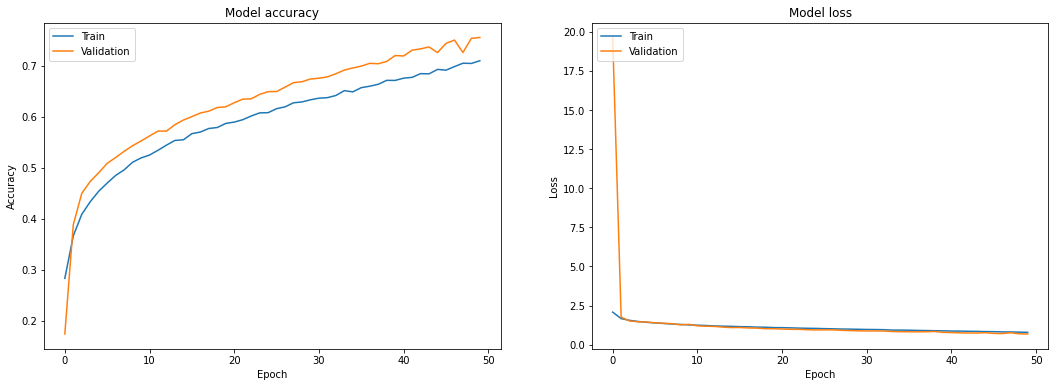

In [37]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['categorical_accuracy'])
axes[0].plot(history.history['val_categorical_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [38]:
score = model.evaluate(data_test_X, data_test_Y, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.6854161620140076 / Test accuracy: 0.7553710341453552
